In [1]:
import os
import sys
import time
import datetime
from glob import glob
import math

from __future__ import division

from models import *
from utils.logger import *
from utils.utils import *
from utils.datasets import * 
from utils.parse_config import *
from test import evaluate

from terminaltables import AsciiTable
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.utils.data as data
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import cv2
from scipy.spatial.transform import Rotation as R
import csv
import numpy as np
import open3d as o3d
from pose_metric import add_ac

# Hyperparameter

In [2]:
print('Num_GPU :', torch.cuda.device_count())

no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
Tensor = torch.cuda.FloatTensor if use_cuda else torch.Tensor

params = {
    "pose_input_size":256,
    "bbox_input_size":512,
    #model params
    "model_def":"config/yolov3.cfg", #path to model definition file
    "class_path":"data/custom/classes.names",
    "conf_thres":0.8,
    "nms_thres":0.4
}

Num_GPU : 2


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# model_bbox

### YOLO-v3

In [4]:
model_bbox = Darknet(params["model_def"])
model_bbox.to(device)

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [5]:
model_bbox.load_state_dict(torch.load(f"checkpoints/DR/yolov3_ckpt_144.pth"))

<All keys matched successfully>

# model_pose

### VGG-16

In [7]:
model_pose = models.vgg16_bn(pretrained=True)

num_features = model_pose.classifier[6].in_features
features = list(model_pose.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 4)])
features.extend([nn.Tanh()])
model_pose.classifier = nn.Sequential(*features)

model_pose = nn.DataParallel(model_pose)
model_pose.to(device)

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0

In [8]:
model_pose.load_state_dict(torch.load("../checkpoints/pose_vgg16/model-258.pt"))

<All keys matched successfully>

### ResNext-50

In [6]:
model_pose = models.resnext50_32x4d(pretrained=True)
num_features = model_pose.fc.in_features
features = list(model_pose.fc.children())[:-1]
features.extend([nn.Linear(num_features, 4)])
features.extend([nn.Tanh()])
model_pose.fc = nn.Sequential(*features)

model_pose = nn.DataParallel(model_pose)
model_pose.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [7]:
model_pose.load_state_dict(torch.load("../checkpoints/pose_resnext50/model-199.pt"))

<All keys matched successfully>

### ResNext-101

In [6]:
model_pose = models.resnext101_32x8d(pretrained=True)
num_features = model_pose.fc.in_features
features = list(model_pose.fc.children())[:-1]
features.extend([nn.Linear(num_features, 4)])
features.extend([nn.Tanh()])
model_pose.fc = nn.Sequential(*features)

model_pose = nn.DataParallel(model_pose)
model_pose.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [7]:
model_pose.load_state_dict(torch.load("../checkpoints/pose_resnext101/model-173.pt"))

<All keys matched successfully>

### Inception-v3

In [6]:
model_pose = models.inception_v3(pretrained=True)
model_pose.aux_logits=False
num_features = model_pose.fc.in_features
features = list(model_pose.fc.children())[:-1]
features.extend([nn.Linear(num_features, 4)])
features.extend([nn.Tanh()])
model_pose.fc = nn.Sequential(*features)

model_pose = nn.DataParallel(model_pose)
model_pose.to(device)

DataParallel(
  (module): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    

In [7]:
model_pose.load_state_dict(torch.load("../checkpoints/pose_inceptionv3/model-100.pt"))

<All keys matched successfully>

# Evaluataion

In [8]:
test_pose = []
f = open("../quat_real.csv", "r")
lines = csv.reader(f)
for line in lines:
    test_pose.append(line)
f.close()
test_pose = np.array([list(map(float, test_pose[i])) for i in range(0,len(test_pose))])

test_image_path = glob.glob("C:/Users/IVCL/Desktop/crane/real_image/*.png")

In [9]:
def visualization(model_bbox, model_pose, img_path, test_pose):
    model_bbox.eval()
    model_pose.eval()
    
    classes = load_classes(params["class_path"])

    image = transforms.ToTensor()(Image.open(img_path).convert("RGB"))
    image = F.interpolate(image.unsqueeze(0), size=params["bbox_input_size"], mode="nearest").squeeze(0)
    
    with torch.no_grad():
        detections = model_bbox(image.unsqueeze(0).to(device))
        detections = non_max_suppression(detections, params["conf_thres"], params["nms_thres"])

    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    img = np.array(Image.open(img_path))
    plt.figure()
    fig, ax = plt.subplots(1)

    pred_bbox = []
    
    if detections[0] is not None:
        detections = rescale_boxes(detections[0], params["bbox_input_size"], img.shape[:2])
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
    
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            pred_bbox.append([math.floor(x1.item()), math.floor(y1.item()),
                              math.floor(x2.item()), math.floor(y2.item())])
            box_w = x2 - x1
            box_h = y2 - y1
            
            cx = math.floor((x2 + x1) / 2)
            cy = math.floor((y2 + y1) / 2)
                                   
            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                       
            # Create a Rectangle patch
            if box_w > box_h:
                bbox = patches.Rectangle((cx-(box_w/2), cy-(box_w/2)), box_w, box_w, linewidth=2, edgecolor=color, facecolor="none")
                
                ax.add_patch(bbox)
                # Add label
                plt.text(
                    cx-(box_w/2),
                    cy-(box_w/2),
                    s=classes[0],
                    color="white",
                    verticalalignment="top", 
                    bbox={"color": color, "pad": 0},
                )
            else:
                bbox = patches.Rectangle((cx-(box_h/2), cy-(box_h/2)), box_h, box_h, linewidth=2, edgecolor=color, facecolor="none")
                ax.add_patch(bbox)
                # Add label
                plt.text(
                    cx-(box_h/2),
                    cy-(box_h/2),
                    s=classes[0],
                    color="white",
                    verticalalignment="top", 
                    bbox={"color": color, "pad": 0},
                )            
            
            #bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
                    
    for bbox in pred_bbox:
        transform = transforms.Compose([
                transforms.Resize(size=(params['pose_input_size'], params['pose_input_size'])),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

        image = Image.open(img_path).convert("RGB")
        x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
        box_w = x2 - x1
        box_h = y2 - y1

        cx = math.floor((x2 + x1) / 2)
        cy = math.floor((y2 + y1) / 2)
        
        if box_w > box_h:
            image = image.crop((cx-box_w/2, cy-box_w/2, cx+box_w/2, cy+box_w/2))
        else:
            image = image.crop((cx-box_h/2, cy-box_h/2, cx+box_h/2, cy+box_h/2))
        image = transform(image).unsqueeze_(0)
        pred_pose = model_pose(image)
    
    test_pose = [test_pose[1], test_pose[2], test_pose[3], test_pose[0]] # convert wxyz to xyzw
    test_pose_euler = R.from_quat(test_pose).as_euler('zyx', degrees=True)
    
    pred_pose = pred_pose[0].cpu().detach().numpy()
    pred_pose = [pred_pose[1], pred_pose[2], pred_pose[3], pred_pose[0]] # convert wxyz to xyzw
    pred_pose_euler = R.from_quat(pred_pose).as_euler('zyx', degrees=True)
    
    ax.imshow(img)
    ax.set_title("Ground Truth Pose(ZYX): {}\nPredicted Pose(ZYX):       {}".format(np.round(test_pose_euler,2),
                                                                                    np.round(pred_pose_euler,2)),loc="left")
    ax.axis("off")
    
    return pred_pose

<ipython-input-9-a5d29c1597f8>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-9-a5d29c1597f8>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


<Figure size 432x288 with 0 Axes>

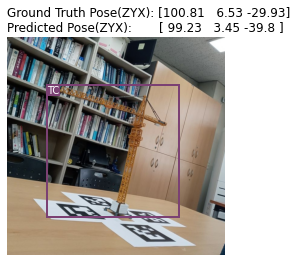

<Figure size 432x288 with 0 Axes>

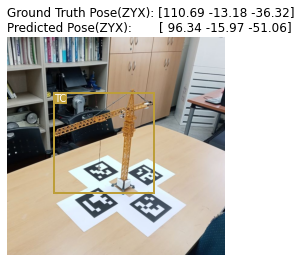

<Figure size 432x288 with 0 Axes>

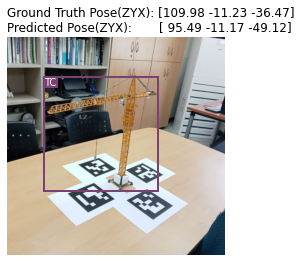

<Figure size 432x288 with 0 Axes>

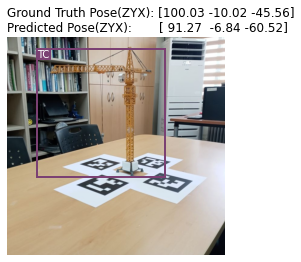

<Figure size 432x288 with 0 Axes>

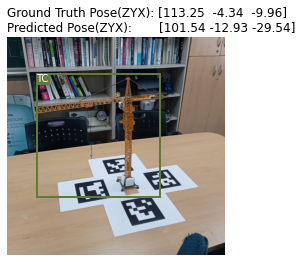

<Figure size 432x288 with 0 Axes>

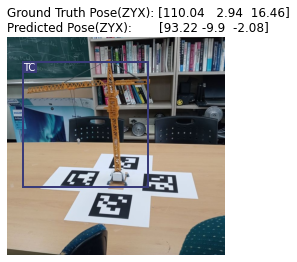

<Figure size 432x288 with 0 Axes>

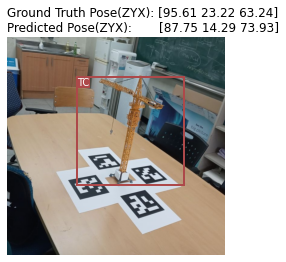

<Figure size 432x288 with 0 Axes>

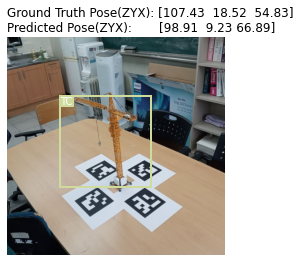

<Figure size 432x288 with 0 Axes>

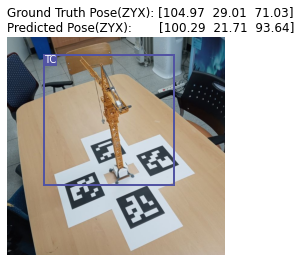

<Figure size 432x288 with 0 Axes>

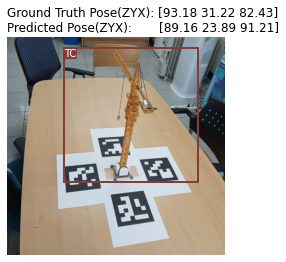

<Figure size 432x288 with 0 Axes>

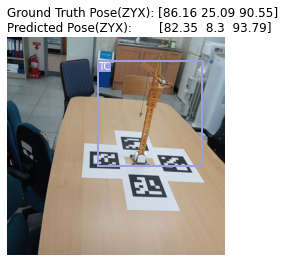

<Figure size 432x288 with 0 Axes>

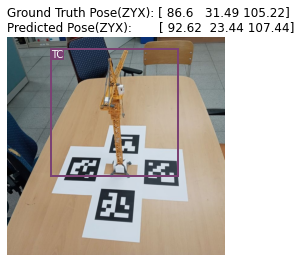

<Figure size 432x288 with 0 Axes>

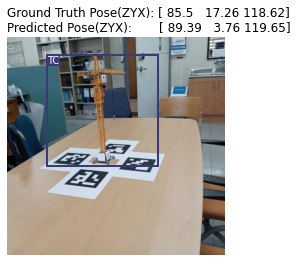

<Figure size 432x288 with 0 Axes>

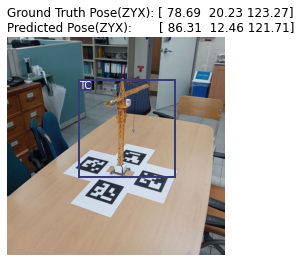

<Figure size 432x288 with 0 Axes>

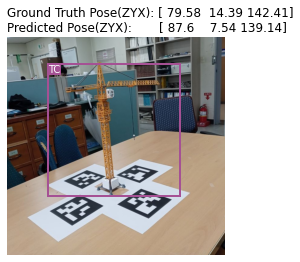

<Figure size 432x288 with 0 Axes>

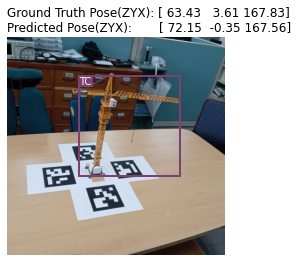

<Figure size 432x288 with 0 Axes>

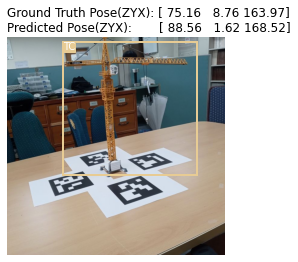

<Figure size 432x288 with 0 Axes>

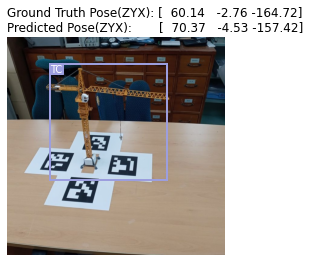

<Figure size 432x288 with 0 Axes>

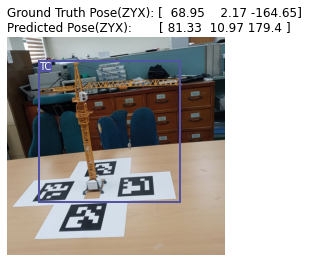

<Figure size 432x288 with 0 Axes>

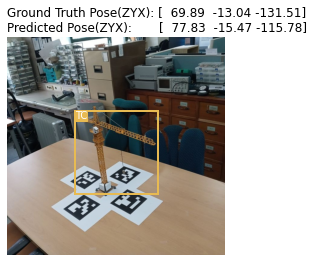

<Figure size 432x288 with 0 Axes>

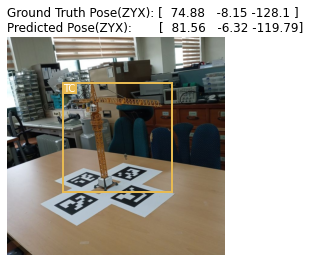

<Figure size 432x288 with 0 Axes>

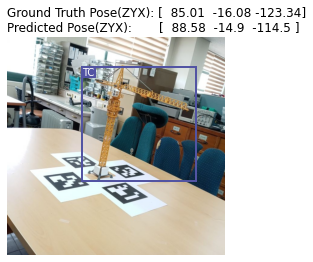

<Figure size 432x288 with 0 Axes>

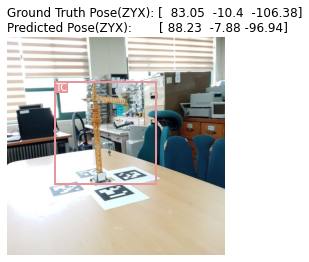

<Figure size 432x288 with 0 Axes>

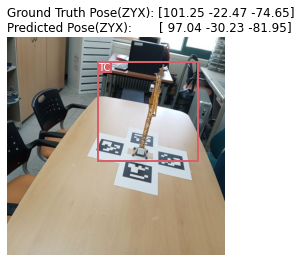

<Figure size 432x288 with 0 Axes>

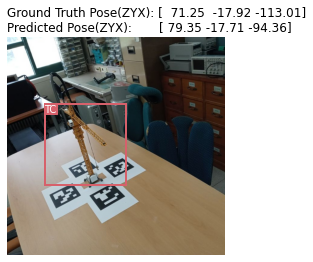

<Figure size 432x288 with 0 Axes>

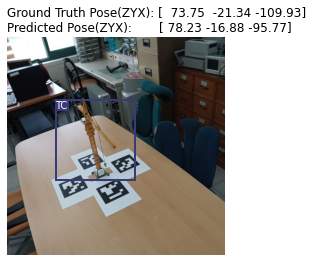

<Figure size 432x288 with 0 Axes>

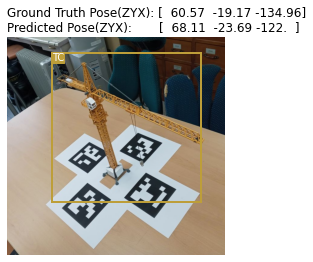

<Figure size 432x288 with 0 Axes>

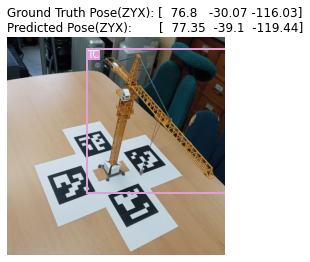

<Figure size 432x288 with 0 Axes>

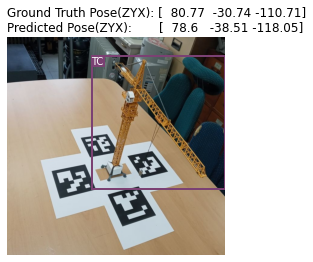

<Figure size 432x288 with 0 Axes>

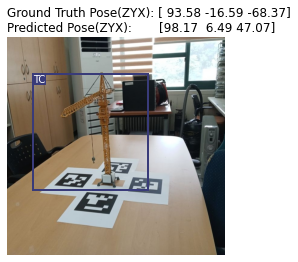

<Figure size 432x288 with 0 Axes>

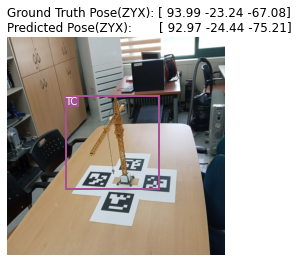

<Figure size 432x288 with 0 Axes>

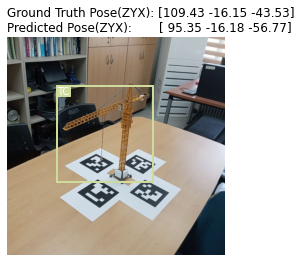

<Figure size 432x288 with 0 Axes>

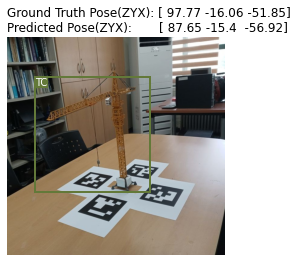

<Figure size 432x288 with 0 Axes>

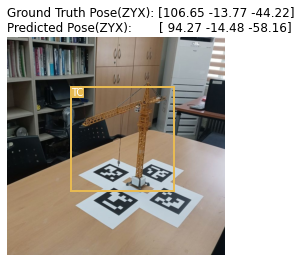

<Figure size 432x288 with 0 Axes>

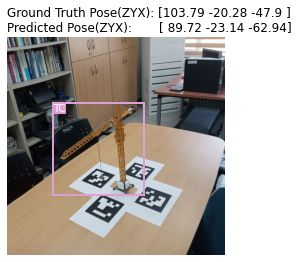

<Figure size 432x288 with 0 Axes>

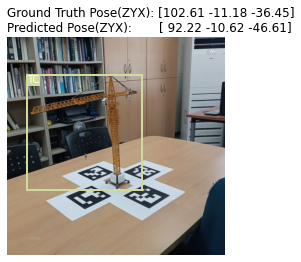

<Figure size 432x288 with 0 Axes>

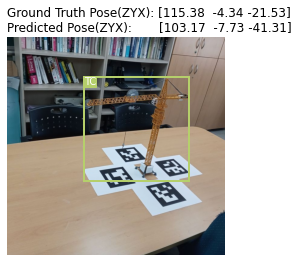

<Figure size 432x288 with 0 Axes>

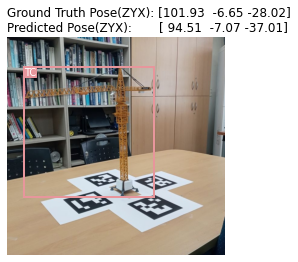

<Figure size 432x288 with 0 Axes>

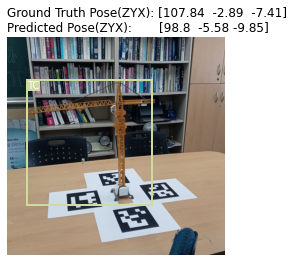

<Figure size 432x288 with 0 Axes>

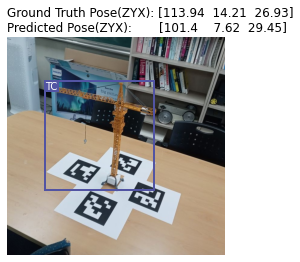

<Figure size 432x288 with 0 Axes>

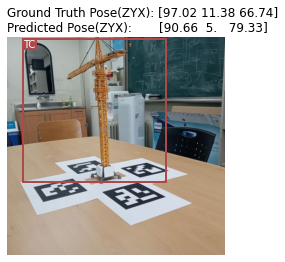

<Figure size 432x288 with 0 Axes>

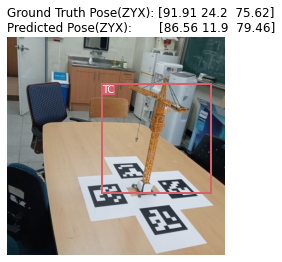

<Figure size 432x288 with 0 Axes>

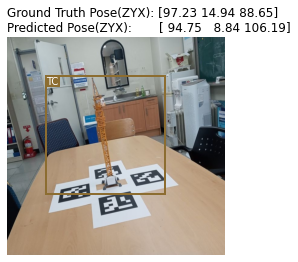

<Figure size 432x288 with 0 Axes>

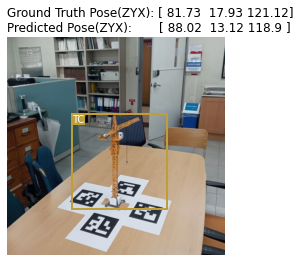

<Figure size 432x288 with 0 Axes>

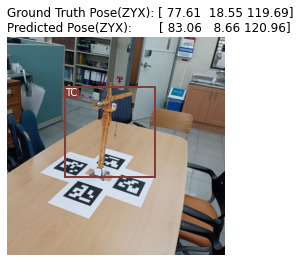

<Figure size 432x288 with 0 Axes>

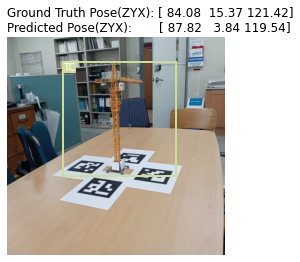

<Figure size 432x288 with 0 Axes>

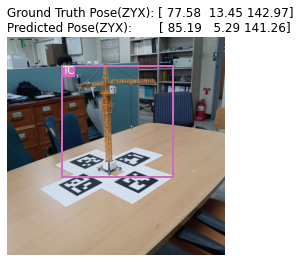

<Figure size 432x288 with 0 Axes>

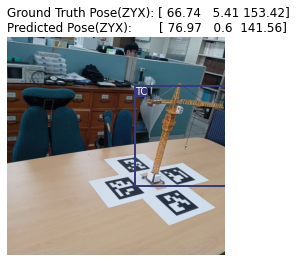

<Figure size 432x288 with 0 Axes>

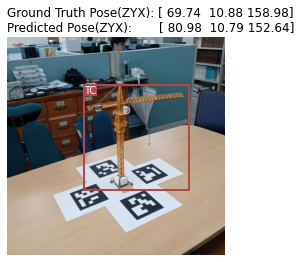

<Figure size 432x288 with 0 Axes>

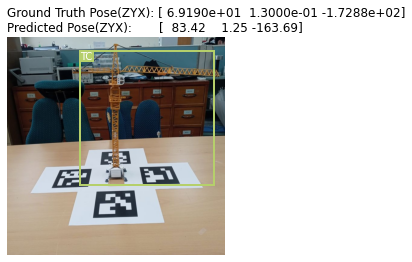

<Figure size 432x288 with 0 Axes>

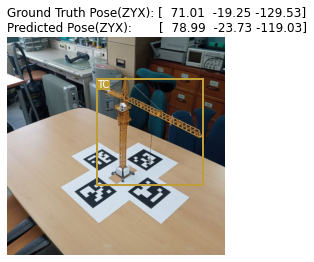

<Figure size 432x288 with 0 Axes>

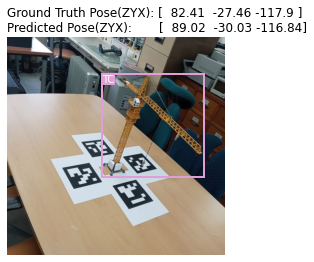

<Figure size 432x288 with 0 Axes>

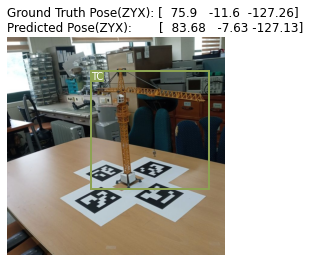

<Figure size 432x288 with 0 Axes>

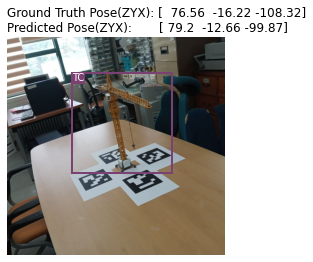

<Figure size 432x288 with 0 Axes>

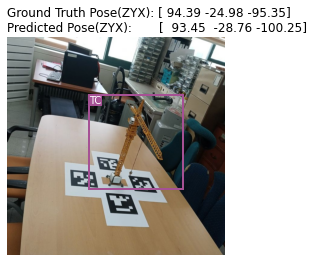

<Figure size 432x288 with 0 Axes>

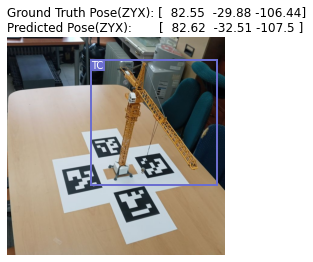

<Figure size 432x288 with 0 Axes>

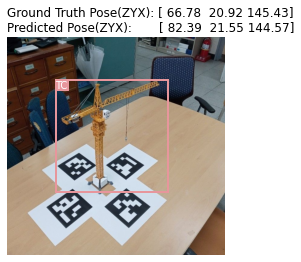

<Figure size 432x288 with 0 Axes>

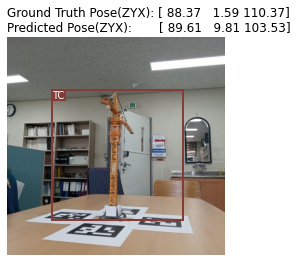

<Figure size 432x288 with 0 Axes>

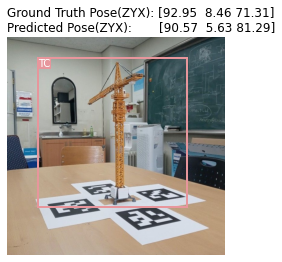

<Figure size 432x288 with 0 Axes>

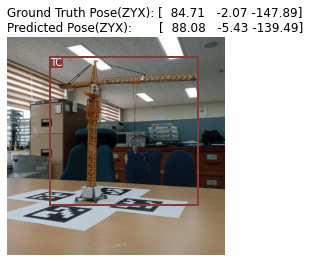

<Figure size 432x288 with 0 Axes>

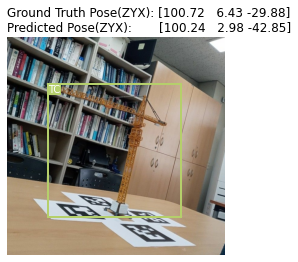

<Figure size 432x288 with 0 Axes>

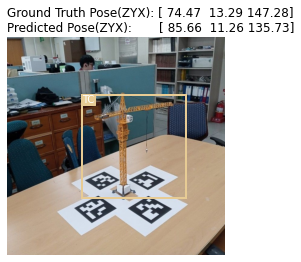

<Figure size 432x288 with 0 Axes>

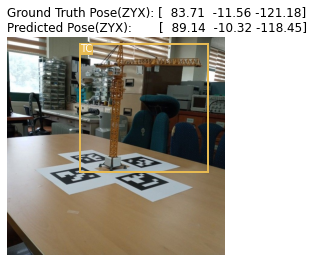

<Figure size 432x288 with 0 Axes>

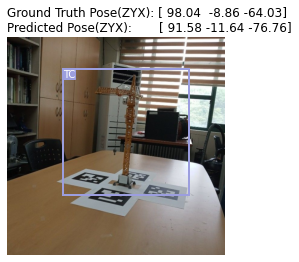

<Figure size 432x288 with 0 Axes>

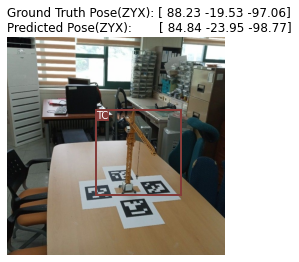

<Figure size 432x288 with 0 Axes>

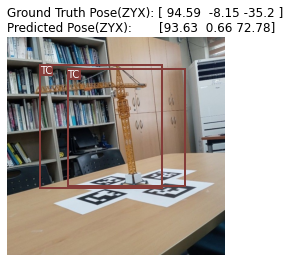

<Figure size 432x288 with 0 Axes>

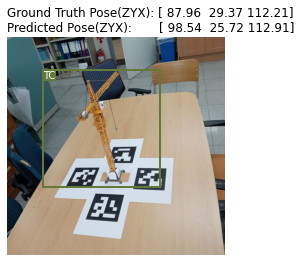

In [10]:
estimated_pose_list = []
for num in range(0, len(test_pose)):
    estimated_pose_list.append(visualization(model_bbox, model_pose, test_image_path[num], test_pose[num]))

In [11]:
pcd = o3d.io.read_point_cloud("../crane.ply")
pcd_array = np.asarray(pcd.points)

In [12]:
test_pose_list_xyzw = [[test_pose[i][1], test_pose[i][2], test_pose[i][3],
                       test_pose[i][0]] for i in range(0, len(test_pose))]

In [13]:
R_gt = R.from_quat(test_pose_list_xyzw).as_dcm()

In [14]:
t_gt = [np.array([[0],[0],[0]]) for i in range(0,len(test_pose_list_xyzw))]
t_e = [np.array([[0],[0],[0]]) for i in range(0,len(test_pose_list_xyzw))]

In [15]:
R_e = [R.from_quat(estimated_pose_list[num]).as_dcm() for num in range(0,len(estimated_pose_list))]

In [16]:
accuracy_list = []

for ths in range(0, 101):
    accuracy = 0
    threshold = ths * 0.01
    for num in range(0, len(test_pose_list_xyzw)):
        accuracy = accuracy + add_ac(R_e[num], t_e[num], R_gt[num], t_gt[num], pcd_array, threshold)
    
    accuracy_list.append(accuracy / len(test_pose_list_xyzw))

ADD : 0.3395051971469929


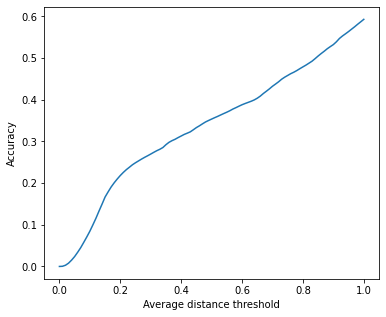

In [17]:
plt.figure(figsize=(6,5))
plt.plot([i*0.01 for i in range(0,101)], accuracy_list)
plt.xlabel("Average distance threshold")
plt.ylabel("Accuracy")

print("ADD :", np.array(accuracy_list).sum() * 0.01)

In [18]:
csvfile=open('../ADD/ADD_inceptionv3.csv','w', newline="")
csvwriter = csv.writer(csvfile)

for row in np.array(accuracy_list).reshape(len(accuracy_list),1):
    csvwriter.writerow(row)
    
csvfile.close()

In [19]:
ADD_vgg16 = []
f = open("../ADD/ADD_vgg16.csv", "r")
lines = csv.reader(f)
for line in lines:
    ADD_vgg16.append(line)
f.close()
ADD_vgg16 = np.array([list(map(float, ADD_vgg16[i])) for i in range(0,len(ADD_vgg16))])

ADD_resnext50 = []
f = open("../ADD/ADD_resnext50.csv", "r")
lines = csv.reader(f)
for line in lines:
    ADD_resnext50.append(line)
f.close()
ADD_resnext50 = np.array([list(map(float, ADD_resnext50[i])) for i in range(0,len(ADD_resnext50))])

ADD_resnext101 = []
f = open("../ADD/ADD_resnext101.csv", "r")
lines = csv.reader(f)
for line in lines:
    ADD_resnext101.append(line)
f.close()
ADD_resnext101 = np.array([list(map(float, ADD_resnext101[i])) for i in range(0,len(ADD_resnext101))])

ADD_inceptionv3 = []
f = open("../ADD/ADD_inceptionv3.csv", "r")
lines = csv.reader(f)
for line in lines:
    ADD_inceptionv3.append(line)
f.close()
ADD_inceptionv3 = np.array([list(map(float, ADD_inceptionv3[i])) for i in range(0,len(ADD_inceptionv3))])

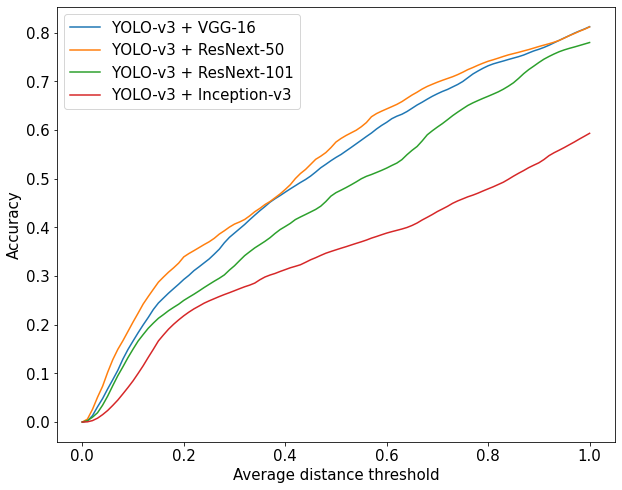

In [22]:
plt.figure(figsize=(10,8))
plt.plot([i*0.01 for i in range(0,101)], ADD_vgg16, label="YOLO-v3 + VGG-16")
plt.plot([i*0.01 for i in range(0,101)], ADD_resnext50, label="YOLO-v3 + ResNext-50")
plt.plot([i*0.01 for i in range(0,101)], ADD_resnext101, label="YOLO-v3 + ResNext-101")
plt.plot([i*0.01 for i in range(0,101)], ADD_inceptionv3, label="YOLO-v3 + Inception-v3")
plt.legend(loc='upper left')
plt.xlabel("Average distance threshold")
plt.ylabel("Accuracy")
plt.rc('font', size=20)
plt.savefig("./ADD.png")

In [2]:
train_DR = []
f = open("../loss/train_loss_yolov3_dr.csv", "r")
lines = csv.reader(f)
for line in lines:
    train_DR.append(line)
f.close()
train_DR = np.array([list(map(float, train_DR[i])) for i in range(0,len(train_DR))])

val_DR = []
f = open("../loss/val_loss_yolov3_dr.csv", "r")
lines = csv.reader(f)
for line in lines:
    val_DR.append(line)
f.close()
val_DR = np.array([list(map(float, val_DR[i])) for i in range(0,len(val_DR))])

train_NODR = []
f = open("../loss/train_loss_yolov3_nodr.csv", "r")
lines = csv.reader(f)
for line in lines:
    train_NODR.append(line)
f.close()
train_NODR = np.array([list(map(float, train_NODR[i])) for i in range(0,len(train_NODR))])

val_NODR = []
f = open("../loss/val_loss_yolov3_nodr.csv", "r")
lines = csv.reader(f)
for line in lines:
    val_NODR.append(line)
f.close()
val_NODR = np.array([list(map(float, val_NODR[i])) for i in range(0,len(val_NODR))])

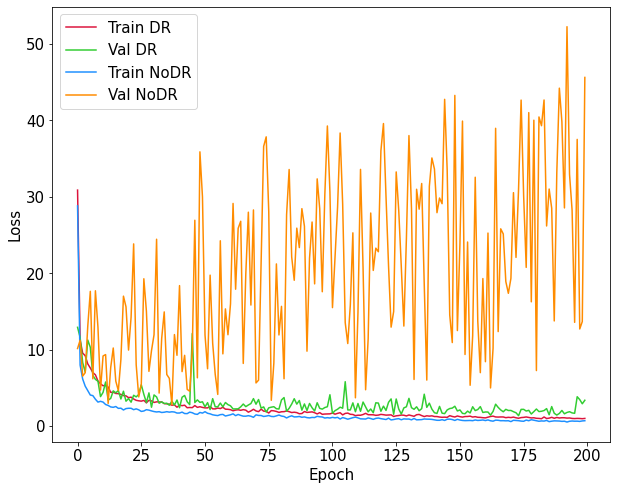

In [9]:
plt.figure(figsize=(10,8))
plt.plot(train_DR, label="Train DR", color="crimson")
plt.plot(val_DR, label="Val DR", color="limegreen")
plt.plot(train_NODR, label="Train NoDR", color="dodgerblue")
plt.plot(val_NODR, label="Val NoDR", color="darkorange")
plt.legend(loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.rc('font', size=20)
plt.savefig("./loss.png")